# Simulacao leitos - camas limitadas

In [323]:
# Import required modules

import simpy
import random
from random import expovariate, seed
import math
import pandas as pd
import matplotlib.pyplot as plt

## leitos

In [324]:
beds_data = pd.read_csv('cnes_leitos.csv', sep = ';')

In [325]:
beds_data.columns

Index(['CNES', 'IBGE', 'leito_sus_cirurgicos', 'leito_sus_clinicos',
       'leito_sus_gineco_obs', 'leito_sus_isolamento', 'leito_sus_outrasespec',
       'leito_sus_pediatricos', 'leito_sus_uci', 'leito_sus_uti'],
      dtype='object')

In [326]:
beds_data.head()

,CNES,IBGE,leito_sus_cirurgicos,leito_sus_clinicos,leito_sus_gineco_obs,leito_sus_isolamento,leito_sus_outrasespec,leito_sus_pediatricos,leito_sus_uci,leito_sus_uti
0,2516500,110001,0,0,0,0,0,0,0,0
1,2679477,110001,6,21,8,2,0,8,0,0
2,2494280,110002,0,0,0,1,0,30,0,0
3,2494299,110002,16,21,27,0,2,1,0,0
4,2515504,110002,0,0,0,0,0,0,0,0


In [327]:
beds_data['total_beds_uci'] = beds_data['leito_sus_uci'] + beds_data['leito_sus_uti']

In [328]:
normal_beds_sum = ['leito_sus_cirurgicos', 'leito_sus_clinicos', 
                   'leito_sus_isolamento', 'leito_sus_outrasespec',
                   'leito_sus_pediatricos']

In [329]:
beds_data['total_beds'] = beds_data[normal_beds_sum].sum(axis=1)

In [330]:
beds_data_filtered = beds_data[beds_data['IBGE'] == 355030]

In [331]:
beds_simulation = beds_data_filtered[['total_beds', 'total_beds_uci']].sum(axis=0)

In [332]:
beds_simulation[0]

12222

In [333]:
beds_simulation[1]

2421

## infectados

In [334]:
covid_data = pd.read_csv('dados_covid.csv')

In [335]:
covid_data.head()

,Unnamed: 0,infectados,hospitalizados
0,0,250.000,89
1,1,282.788,101
2,2,311.830,112
3,3,338.364,121
4,4,363.370,130


In [336]:
covid_data.shape[0]

180

## simulation

In [337]:
class g:
    """g holds Global variables. No individual instance is required"""
    
    has_covid = 1
    covid_cases = covid_data
    cases_arriving = 305
    
    inter_arrival_time = 1/cases_arriving  # Average time (days) between arrivals
    los = 8  # Average length of stay in hospital (days)
    los_uti = 7  # Average length of stay in hospital (days)
    
    los_covid = 10  # Average length of stay in hospital (days)
    los_covid_uti = 7
    
    sim_duration = covid_data.shape[0]  # Duration of simulation (days)
    audit_interval = 1  # Interval between audits (days)
    
    total_beds = 12222
    total_beds_icu = 2421
    occupation_rate = 0.8
    icu_occupation_rate = 0.8
    
    icu_rate = 0.1
    icu_after_bed = 0.08
    
    beds = int(total_beds * (1 - occupation_rate))  # beds available
    icu_beds = int(total_beds_icu * (1 - icu_occupation_rate)) # icu beds available

In [338]:
class Hospital:
    """
    Hospital class holds:
    1) Dictionary of patients present
    2) List of audit times
    3) List of beds occupied at each audit time
    4) Current total beds occupied
    5) Current total icu beds occupied
    6) Admissions to data

    Methods:

    __init__: Set up hospital instance

    audit: records number of beds occupied

    build_audit_report: builds audit report at end of run (calculate 5th, 50th
    and 95th percentile bed occupancy.

    chart: plot beds occupied over time (at end of run)
    """

    def __init__(self):
        """
        Constructor method for hospital class"
        Initialise object with attributes.
        """

        self.patients = {}  # Dictionary of patients present
        self.patients_in_queue = {}
        
        self.patients_in_beds = {}
        self.patients_in_icu_beds = {}
        
        self.audit_time = []  # List of audit times
        self.audit_beds = []  # List of beds occupied at each audit time
        self.audit_icu_beds = []  # List of icu beds occupied at each audit time
        self.audit_queue = []
        
        self.bed_count = 0  # Current total beds occupied
        self.bed_icu_count = 0
        self.queue_count = 0
        self.admissions = 0  # Admissions to data
        
        return

    def audit(self, time):
        """
        Audit method. When called appends current simulation time to audit_time
        list, and appends current bed count to audit_beds.
        """
        self.audit_time.append(time)
        self.audit_beds.append(self.bed_count)
        self.audit_icu_beds.append(self.bed_icu_count)
        self.audit_queue.append(self.queue_count)
        
        return

    def build_audit_report(self):
        """
        This method is called at end of run. It creates a pandas DataFrame,
        transfers audit times and bed counts to the DataFrame, and 
        calculates/stores 5th, 50th and 95th percentiles.
        """
        self.audit_report = pd.DataFrame()

        self.audit_report['Time'] = self.audit_time

        self.audit_report['Occupied_beds'] = self.audit_beds
        
        self.audit_report['ICU_Occupied_beds'] = self.audit_icu_beds

        self.audit_report['Median_beds'] = \
            self.audit_report['Occupied_beds'].quantile(0.5)
        
        self.audit_report['ICU_Median_beds'] = \
            self.audit_report['ICU_Occupied_beds'].quantile(0.5)

        self.audit_report['Beds_5_percent'] = \
            self.audit_report['Occupied_beds'].quantile(0.05)

        self.audit_report['ICU_Beds_5_percent'] = \
            self.audit_report['ICU_Occupied_beds'].quantile(0.05)
        
        self.audit_report['Beds_95_percent'] = \
            self.audit_report['Occupied_beds'].quantile(0.95)
        
        self.audit_report['ICU_Beds_95_percent'] = \
            self.audit_report['ICU_Occupied_beds'].quantile(0.95)

        self.audit_report['Queue'] = self.audit_queue

        self.audit_report['Median_queue'] = \
            self.audit_report['Queue'].quantile(0.5)

        self.audit_report['Queue_5_percent'] = \
            self.audit_report['Queue'].quantile(0.05)

        self.audit_report['Queue_95_percent'] = \
            self.audit_report['Queue'].quantile(0.95)

        return self.audit_report

    def chart(self):
        """
        This method is called at end of run. It plots beds occupancy over the
        model run, with 5%, 50% and 95% percentiles.
        """

        # Plot occupied beds

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Occupied_beds'],
                 color='k',
                 marker='o',
                 linestyle='solid',
                 markevery=1,
                 label='Occupied beds')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Beds_5_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 markevery=1,
                 label='5th percentile')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Median_beds'],
                 color='0.5',
                 linestyle='dashed',
                 label='Median')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Beds_95_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 label='95th percentile')

        plt.xlabel('Day')
        plt.ylabel('Occupied beds')
        plt.title(
            'Occupied beds (individual days with 5th, 50th and 95th ' +
            'percentiles)')
        plt.legend()
        plt.show()
        
        
        # Plot occupied icu beds

        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Occupied_beds'],
                 color='k',
                 marker='o',
                 linestyle='solid',
                 markevery=1,
                 label='Occupied icu beds')
        
        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Beds_5_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 markevery=1,
                 label='5th percentile')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Median_beds'],
                 color='0.5',
                 linestyle='dashed',
                 label='Median')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['ICU_Beds_95_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 label='95th percentile')
        
        plt.xlabel('Day')
        plt.ylabel('Occupied icu beds')
        plt.title(
            'Occupied icu beds (individual days with 5th, 50th and 95th ' +
            'percentiles)')
        plt.legend()
        plt.show()
        

        # Plot queue for beds

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Queue'],
                 color='k',
                 marker='o',
                 linestyle='solid',
                 markevery=1, label='Occupied beds')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Queue_5_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 markevery=1,
                 label='5th percentile')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Median_queue'],
                 color='0.5',
                 linestyle='dashed',
                 label='Median')

        plt.plot(self.audit_report['Time'],
                 self.audit_report['Queue_95_percent'],
                 color='0.5',
                 linestyle='dashdot',
                 label='95th percentile')

        plt.xlabel('Day')
        plt.ylabel('Queue for hospital attendance')
        plt.title('Queue for hospital attendance (individual days with 5th, 50th and 95th' +
                  ' percentiles)')
        plt.legend()
        plt.show()

        return

In [339]:
class Model:
    """
    The main model class.

    The model class contains the model environment. The modelling environment
    is set up, and patient arrival and audit processes initiated. Patient
    arrival triggers a spell for that patient in hospital. Arrivals and audit
    continue for the duration of the model run. The audit is then 
    summarised and bed occupancy (with 5th, 50th and 95th percentiles) plotted.

    Methods are:

    __init__: Set up model instance

    audit_beds: call for bed audit at regular intervals (after initial delay 
    for model warm-up)

    new_admission: trigger new admissions to hospital at regular intervals.
    Call for patient generation with patient id and length of stay, then call
    for patient spell in hospital.

    run: Controls the main model run. Initialises model and patient arrival and
    audit processes. Instigates the run. At end of run calls for an audit
    summary and bed occupancy plot.

    spell_gen: stores patient in hospital patient list and bed queue 
    dictionaries, waits for bed resource to become available, then removes 
    patient from bed queue dictionary and adds patient to hospital bed 
    dictionary and increments beds occupied. Waits for the patient length of
    stay in the hospital and then decrements beds occupied and removes patient
    from hospital patient dictionary and beds occupied dictionary.
    """

    def __init__(self):
        """
        Constructor class for new model.
        """
        self.env = simpy.Environment()

        return

    def audit_beds(self, delay):
        """
        Bed audit process. Begins by applying delay, then calls for audit at
        intervals set in g.audit_interval

        :param delay: delay (days) at start of model run for model warm-up.
        """

        # Delay first audit
        yield self.env.timeout(delay)

        # Continually generate audit requests until end of model run
        while True:
            # Call audit (pass simulation time to hospital.audit)
            self.hospital.audit(self.env.now)
            # Delay until next call
            yield self.env.timeout(g.audit_interval)

        return

    def new_admission(self, interarrival_time, los, los_uti):
        """
        New admissions to hospital.

        :param interarrival_time: average time (days) between arrivals
        :param los: average length of stay (days)
        """
        while True:
            # Increment hospital admissions count
            self.hospital.admissions += 1
            
            # Generate new patient object (from Patient class). Give patient id
            # and set length of stay from inverse exponential distribution).
            
            if g.has_covid == 1:
                p = Patient(patient_id=self.hospital.admissions,
                            los=random.expovariate(1 / ((los + g.los_covid)/2) ),
                            los_uti=random.expovariate(1 / ((los_uti + g.los_covid_uti)/2) ))
            else:
                p = Patient(patient_id=self.hospital.admissions,
                            los=random.expovariate(1 / los),
                            los_uti=random.expovariate(1 / los_uti))
            
            #print('Patient %d arriving %7.2f, admissions count %d' %(p.id,self.env.now,self.hospital.admissions))

            # Add patient to hospital patient dictionary
            self.hospital.patients[p.id] = p

            # Generate a patient spell in hospital (by calling spell method).
            # This triggers a patient admission and allows the next arrival to
            # be set before the paitent spell is finished
            self.spell = self.spell_gen(p)
            self.env.process(self.spell)

            # Set and call delay before looping back to new patient admission
            
            if g.has_covid == 1:
                inter_arrival_covid = 1 / g.covid_cases['hospitalizados'][math.floor(self.env.now)]
                next_admission = random.expovariate(1 / ((interarrival_time + inter_arrival_covid)/2) )
            else:
                next_admission = random.expovariate(1 / interarrival_time)
            
            
            #next_admission = random.expovariate(1 / interarrival_time)
                        
            yield self.env.timeout(next_admission)

        return

    def spell_gen(self, p):
        """
        Patient hospital stay generator. Increment bed count, wait for patient
        length of stay to complete, then decrement bed count and remove patient
        from hospital patient dictionary

        :param p: patient object (contains length of stay for patient)
        """
        # The following 'with' defines the required resources and automatically
        # releases resources when no longer required
        
        # screening - bed or icu bed
        is_icu = 1 if random.uniform(0, 1) > (1-g.icu_rate) else 0
        
        # bed
        if is_icu == 0:
            
            with self.resources.beds.request() as req:
                # Increment queue count
                self.hospital.queue_count += 1
                #print('Patient %d arriving queue %7.2f, queue count %d' %(p.id,self.env.now,self.hospital.queue_count))

                # Add patient to dictionary of queuing patients. This is not used
                # further in this model.
                self.hospital.patients_in_queue[p.id] = p

                # Yield resource request. Sim continues after yield when resources
                # are vailable (so there is no delay if resources are immediately
                # available)
                yield req

                # Resource now available. Remove from queue count and dictionary of
                # queued objects
                self.hospital.queue_count -= 1
                del self.hospital.patients_in_queue[p.id]
                #print('Patient %d leaving queue %7.2f, queue count %d' %(p.id,self.env.now,self.hospital.queue_count))

                # Add to count of patients in beds and to dictionary of patients in
                # beds
                self.hospital.patients_in_beds[p.id] = p
                self.hospital.bed_count += 1
                #print('Patient %d arriving bed %7.2f, bed count %d' %(p.id,self.env.now,self.hospital.bed_count))

                # Trigger length of stay delay
                yield self.env.timeout(p.los)

                # Length of stay complete. Remove patient from counts and
                # dictionaries
                self.hospital.bed_count -= 1
                #print('Patient %d leaving bed %7.2f, bed count %d' %(p.id,self.env.now,self.hospital.bed_count))
                del self.hospital.patients_in_beds[p.id]
            
            # needs icu
            after_is_icu = 1 if random.uniform(0, 1) > (1-g.icu_after_bed) else 0
            
            if after_is_icu == 1:
                
                with self.resources_icu.icu_beds.request() as icu_req:
                    
                    # Increment queue count
                    self.hospital.bed_count += 1
                    #print('Patient %d waiting icu %7.2f, bed count %d' %(p.id,self.env.now,self.hospital.bed_count))
                
                    # Add patient to dictionary of icu queuing patients. This is not used
                    # further in this model.
                    self.hospital.patients_in_beds[p.id] = p
                
                    # Yield resource request. Sim continues after yield when resources
                    # are vailable (so there is no delay if resources are immediately
                    # available)
                    yield icu_req
                
                    # Resource now available. Remove from queue count and dictionary of
                    # queued objects
                    self.hospital.bed_count -= 1
                    del self.hospital.patients_in_beds[p.id]
                    #print('Patient %d leaving bed %7.2f, queue bed %d' %(p.id,self.env.now,self.hospital.bed_count))
                
                    # Add to count of patients in icu beds and to dictionary of patients in
                    # icu beds
                    self.hospital.patients_in_icu_beds[p.id] = p
                    self.hospital.bed_icu_count += 1
                    print('Patient %d arriving icu bed %7.2f, icu bed count %d' %(p.id,self.env.now,self.hospital.bed_icu_count))
                
                    # Trigger length of stay delay
                    yield self.env.timeout(p.los_uti)
                
                    # Length of stay complete. Remove patient from counts and
                    # dictionaries
                    self.hospital.bed_icu_count -= 1
                    #print('Patient %d leaving icu bed %7.2f, icu bed count %d' %(p.id,self.env.now,self.hospital.bed_icu_count))
                    del self.hospital.patients_in_icu_beds[p.id]
                    del self.hospital.patients[p.id]
        
        # icu bed
        else:
                    
            with self.resources_icu.icu_beds.request() as icu_req:
                
                # Increment queue count
                self.hospital.queue_count += 1
                #print('Patient %d arriving queue %7.2f, queue count %d' %(p.id,self.env.now,self.hospital.queue_count))
                
                # Add patient to dictionary of icu queuing patients. This is not used
                # further in this model.
                self.hospital.patients_in_queue[p.id] = p
                
                # Yield resource request. Sim continues after yield when resources
                # are vailable (so there is no delay if resources are immediately
                # available)
                yield icu_req
                
                # Resource now available. Remove from queue count and dictionary of
                # queued objects
                self.hospital.queue_count -= 1
                del self.hospital.patients_in_queue[p.id]
                #print('Patient %d leaving queue %7.2f, queue count %d' %(p.id,self.env.now,self.hospital.queue_count))
                
                # Add to count of patients in icu beds and to dictionary of patients in
                # icu beds
                self.hospital.patients_in_icu_beds[p.id] = p
                self.hospital.bed_icu_count += 1
                #print('Patient %d arriving icu bed %7.2f, icu bed count %d' %(p.id,self.env.now,self.hospital.bed_icu_count))
                
                # Trigger length of stay delay
                yield self.env.timeout(p.los_uti)
                
                # Length of stay complete. Remove patient from counts and
                # dictionaries
                self.hospital.bed_icu_count -= 1
                #print('Patient %d leaving icu bed %7.2f, icu bed count %d' %(p.id,self.env.now,self.hospital.bed_icu_count))
                del self.hospital.patients_in_icu_beds[p.id]
                del self.hospital.patients[p.id]

        return
    
    def run(self):
        """
        Controls the main model run. Initialises model and patient arrival and
        audit processes. Instigates the run. At end of run calls for an audit
        summary and bed occupancy plot
        """

        # Set up hospital (calling Hospital class)
        self.hospital = Hospital()

        # Set up resources (beds, icu_beds)
        self.resources = Resources(self.env, g.beds)
        self.resources_icu = Resources_ICU(self.env, g.icu_beds)

        # Set up starting processes: new admissions and bed  audit (with delay)
        self.env.process(self.new_admission(g.inter_arrival_time, g.los, g.los_uti))
        self.env.process(self.audit_beds(delay=20))

        # Start model run
        self.env.run(until=g.sim_duration)

        # At end of run call for bed audit summary and bed occupancy plot
        self.hospital.build_audit_report()
        #self.hospital.chart()

        return

In [340]:
class Patient:
    """
    Patient class. Contains patient id and length of stay (it could contain
    other info about patient, such as priority or clinical group.

    The only method is __init__ for creating a patient (with assignment of
    patient id and length of stay).
    """

    def __init__(self, patient_id, los, los_uti):
        """
        Contructor for new patient.

        :param patient_id: id of patient  (set in self.new_admission)
        :param los: length of stay (days, set in self.new_admission)
        """
        self.id = patient_id
        self.los = los
        self.los_uti = los_uti

        return

In [341]:
class Resources:
    """
    Holds beds resources
    """

    def __init__(self, env, number_of_beds):
        """        Constructor method to initialise beds resource)"""
        self.beds = simpy.Resource(env, capacity=number_of_beds)

        return

In [342]:
class Resources_ICU:
    """
    Holds icu beds resources
    """

    def __init__(self, env, number_of_icu_beds):
        """        Constructor method to initialise icu beds resource)"""
        self.icu_beds = simpy.Resource(env, capacity=number_of_icu_beds)

        return

In [343]:
def main():
    """
    Code entry point after: if __name__ == '__main__'
    Creates model object, and runs model
    """

    model = Model()
    model.run()

    return

In [344]:
## Code entry point. Calls main method.
#if __name__ == '__main__':
#    main()

In [345]:
model = Model()

In [346]:
%%time
seed(98989)
model.run()

Patient 129 arriving icu bed    1.19, icu bed count 20
Patient 113 arriving icu bed    1.20, icu bed count 21
Patient 66 arriving icu bed    1.23, icu bed count 22
Patient 178 arriving icu bed    1.24, icu bed count 23
Patient 135 arriving icu bed    2.56, icu bed count 32
Patient 297 arriving icu bed    2.94, icu bed count 35
Patient 286 arriving icu bed    3.15, icu bed count 39
Patient 393 arriving icu bed    3.98, icu bed count 47
Patient 389 arriving icu bed    4.12, icu bed count 47
Patient 613 arriving icu bed    4.53, icu bed count 50
Patient 709 arriving icu bed    4.99, icu bed count 47
Patient 704 arriving icu bed    5.00, icu bed count 49
Patient 198 arriving icu bed    5.02, icu bed count 50
Patient 164 arriving icu bed    5.04, icu bed count 51
Patient 593 arriving icu bed    5.31, icu bed count 52
Patient 701 arriving icu bed    5.32, icu bed count 53
Patient 494 arriving icu bed    5.37, icu bed count 52
Patient 57 arriving icu bed    5.38, icu bed count 53
Patient 780 

Patient 4709 arriving icu bed   21.85, icu bed count 247
Patient 3799 arriving icu bed   21.87, icu bed count 246
Patient 3172 arriving icu bed   21.87, icu bed count 247
Patient 4834 arriving icu bed   22.15, icu bed count 254
Patient 4093 arriving icu bed   22.19, icu bed count 254
Patient 3476 arriving icu bed   22.24, icu bed count 255
Patient 2383 arriving icu bed   22.30, icu bed count 252
Patient 5203 arriving icu bed   22.43, icu bed count 251
Patient 5186 arriving icu bed   22.52, icu bed count 259
Patient 4625 arriving icu bed   22.59, icu bed count 260
Patient 5202 arriving icu bed   22.59, icu bed count 263
Patient 2388 arriving icu bed   22.60, icu bed count 263
Patient 1336 arriving icu bed   22.61, icu bed count 265
Patient 4506 arriving icu bed   22.61, icu bed count 266
Patient 4405 arriving icu bed   22.62, icu bed count 268
Patient 5342 arriving icu bed   22.64, icu bed count 269
Patient 3733 arriving icu bed   22.65, icu bed count 271
Patient 4442 arriving icu bed  

Patient 5435 arriving icu bed   29.58, icu bed count 372
Patient 4301 arriving icu bed   29.61, icu bed count 377
Patient 2762 arriving icu bed   29.63, icu bed count 381
Patient 5905 arriving icu bed   29.72, icu bed count 378
Patient 6172 arriving icu bed   29.73, icu bed count 380
Patient 2733 arriving icu bed   29.75, icu bed count 383
Patient 5259 arriving icu bed   29.80, icu bed count 384
Patient 7815 arriving icu bed   29.80, icu bed count 385
Patient 2860 arriving icu bed   29.88, icu bed count 385
Patient 3930 arriving icu bed   29.88, icu bed count 386
Patient 7473 arriving icu bed   29.99, icu bed count 385
Patient 5944 arriving icu bed   30.19, icu bed count 381
Patient 2377 arriving icu bed   30.22, icu bed count 383
Patient 4280 arriving icu bed   30.23, icu bed count 384
Patient 7088 arriving icu bed   30.30, icu bed count 381
Patient 4738 arriving icu bed   30.31, icu bed count 382
Patient 7601 arriving icu bed   30.32, icu bed count 381
Patient 6032 arriving icu bed  

Patient 1522 arriving icu bed   37.03, icu bed count 449
Patient 1841 arriving icu bed   37.07, icu bed count 453
Patient 9522 arriving icu bed   37.07, icu bed count 455
Patient 8138 arriving icu bed   37.08, icu bed count 456
Patient 9785 arriving icu bed   37.10, icu bed count 457
Patient 3213 arriving icu bed   37.14, icu bed count 454
Patient 9713 arriving icu bed   37.29, icu bed count 458
Patient 9380 arriving icu bed   37.35, icu bed count 452
Patient 7044 arriving icu bed   37.42, icu bed count 453
Patient 10104 arriving icu bed   37.45, icu bed count 452
Patient 9149 arriving icu bed   37.48, icu bed count 453
Patient 9963 arriving icu bed   37.57, icu bed count 450
Patient 7074 arriving icu bed   37.58, icu bed count 451
Patient 9398 arriving icu bed   37.65, icu bed count 448
Patient 8507 arriving icu bed   37.81, icu bed count 450
Patient 8515 arriving icu bed   37.89, icu bed count 449
Patient 9999 arriving icu bed   37.92, icu bed count 450
Patient 10293 arriving icu bed

Patient 12102 arriving icu bed   44.45, icu bed count 447
Patient 11170 arriving icu bed   44.46, icu bed count 447
Patient 10657 arriving icu bed   44.55, icu bed count 446
Patient 10124 arriving icu bed   44.61, icu bed count 452
Patient 12156 arriving icu bed   44.73, icu bed count 456
Patient 7598 arriving icu bed   44.73, icu bed count 457
Patient 12314 arriving icu bed   44.76, icu bed count 458
Patient 8429 arriving icu bed   44.76, icu bed count 459
Patient 8345 arriving icu bed   44.78, icu bed count 458
Patient 11627 arriving icu bed   44.90, icu bed count 463
Patient 11717 arriving icu bed   44.90, icu bed count 464
Patient 9823 arriving icu bed   44.91, icu bed count 463
Patient 10709 arriving icu bed   44.95, icu bed count 462
Patient 9120 arriving icu bed   44.96, icu bed count 462
Patient 10692 arriving icu bed   44.97, icu bed count 461
Patient 10477 arriving icu bed   45.09, icu bed count 459
Patient 11383 arriving icu bed   45.11, icu bed count 462
Patient 12245 arriv

Patient 14284 arriving icu bed   51.87, icu bed count 484
Patient 12768 arriving icu bed   52.03, icu bed count 484
Patient 8691 arriving icu bed   52.03, icu bed count 484
Patient 11472 arriving icu bed   52.09, icu bed count 484
Patient 12732 arriving icu bed   52.10, icu bed count 484
Patient 8919 arriving icu bed   52.11, icu bed count 484
Patient 14346 arriving icu bed   52.12, icu bed count 484
Patient 13159 arriving icu bed   52.14, icu bed count 484
Patient 13631 arriving icu bed   52.16, icu bed count 484
Patient 13474 arriving icu bed   52.16, icu bed count 484
Patient 11341 arriving icu bed   52.17, icu bed count 484
Patient 13123 arriving icu bed   52.28, icu bed count 484
Patient 13483 arriving icu bed   52.34, icu bed count 484
Patient 13916 arriving icu bed   52.37, icu bed count 484
Patient 13768 arriving icu bed   52.47, icu bed count 484
Patient 13284 arriving icu bed   52.62, icu bed count 484
Patient 12491 arriving icu bed   52.69, icu bed count 484
Patient 14132 ar

Patient 14253 arriving icu bed   60.93, icu bed count 484
Patient 16408 arriving icu bed   61.05, icu bed count 484
Patient 14222 arriving icu bed   61.23, icu bed count 484
Patient 16842 arriving icu bed   61.28, icu bed count 484
Patient 15995 arriving icu bed   61.30, icu bed count 484
Patient 9608 arriving icu bed   61.41, icu bed count 484
Patient 16760 arriving icu bed   61.61, icu bed count 484
Patient 15351 arriving icu bed   61.62, icu bed count 484
Patient 13189 arriving icu bed   61.62, icu bed count 484
Patient 16362 arriving icu bed   61.63, icu bed count 484
Patient 16852 arriving icu bed   61.64, icu bed count 484
Patient 14963 arriving icu bed   61.66, icu bed count 484
Patient 12342 arriving icu bed   61.68, icu bed count 484
Patient 17081 arriving icu bed   61.69, icu bed count 484
Patient 17353 arriving icu bed   61.73, icu bed count 484
Patient 11818 arriving icu bed   61.76, icu bed count 484
Patient 16789 arriving icu bed   61.78, icu bed count 484
Patient 16734 a

Patient 16980 arriving icu bed   71.11, icu bed count 484
Patient 19052 arriving icu bed   71.18, icu bed count 484
Patient 17991 arriving icu bed   71.20, icu bed count 484
Patient 15866 arriving icu bed   71.24, icu bed count 484
Patient 17550 arriving icu bed   71.28, icu bed count 484
Patient 18430 arriving icu bed   71.29, icu bed count 484
Patient 16588 arriving icu bed   71.30, icu bed count 484
Patient 19175 arriving icu bed   71.31, icu bed count 484
Patient 19942 arriving icu bed   71.36, icu bed count 484
Patient 18850 arriving icu bed   71.38, icu bed count 484
Patient 19440 arriving icu bed   71.51, icu bed count 484
Patient 6083 arriving icu bed   71.59, icu bed count 484
Patient 18775 arriving icu bed   71.68, icu bed count 484
Patient 19536 arriving icu bed   71.74, icu bed count 484
Patient 10926 arriving icu bed   71.87, icu bed count 484
Patient 18900 arriving icu bed   71.89, icu bed count 484
Patient 18845 arriving icu bed   72.02, icu bed count 484
Patient 16906 a

Patient 20201 arriving icu bed   79.84, icu bed count 484
Patient 19519 arriving icu bed   79.93, icu bed count 484
Patient 22018 arriving icu bed   80.08, icu bed count 484
Patient 17856 arriving icu bed   80.11, icu bed count 484
Patient 15739 arriving icu bed   80.23, icu bed count 484
Patient 16602 arriving icu bed   80.27, icu bed count 484
Patient 20859 arriving icu bed   80.29, icu bed count 484
Patient 16094 arriving icu bed   80.33, icu bed count 484
Patient 20332 arriving icu bed   80.38, icu bed count 484
Patient 18699 arriving icu bed   80.51, icu bed count 484
Patient 22039 arriving icu bed   80.56, icu bed count 484
Patient 15315 arriving icu bed   80.65, icu bed count 484
Patient 21467 arriving icu bed   80.67, icu bed count 484
Patient 22243 arriving icu bed   80.68, icu bed count 484
Patient 21991 arriving icu bed   80.83, icu bed count 484
Patient 16989 arriving icu bed   80.99, icu bed count 484
Patient 22272 arriving icu bed   81.04, icu bed count 484
Patient 22164 

Patient 21034 arriving icu bed   88.61, icu bed count 484
Patient 19669 arriving icu bed   88.65, icu bed count 484
Patient 21328 arriving icu bed   88.69, icu bed count 484
Patient 23376 arriving icu bed   88.71, icu bed count 484
Patient 23023 arriving icu bed   88.74, icu bed count 484
Patient 23570 arriving icu bed   88.80, icu bed count 484
Patient 24338 arriving icu bed   88.84, icu bed count 484
Patient 20956 arriving icu bed   88.88, icu bed count 484
Patient 21789 arriving icu bed   88.94, icu bed count 484
Patient 21513 arriving icu bed   88.94, icu bed count 484
Patient 23494 arriving icu bed   88.99, icu bed count 484
Patient 23210 arriving icu bed   89.03, icu bed count 484
Patient 19676 arriving icu bed   89.15, icu bed count 484
Patient 23858 arriving icu bed   89.21, icu bed count 484
Patient 24222 arriving icu bed   89.21, icu bed count 484
Patient 22730 arriving icu bed   89.30, icu bed count 484
Patient 22348 arriving icu bed   89.33, icu bed count 484
Patient 19791 

Patient 25104 arriving icu bed   98.09, icu bed count 484
Patient 23545 arriving icu bed   98.12, icu bed count 484
Patient 20494 arriving icu bed   98.20, icu bed count 484
Patient 22666 arriving icu bed   98.22, icu bed count 484
Patient 24606 arriving icu bed   98.26, icu bed count 484
Patient 22720 arriving icu bed   98.34, icu bed count 484
Patient 24459 arriving icu bed   98.62, icu bed count 484
Patient 25649 arriving icu bed   98.69, icu bed count 484
Patient 24940 arriving icu bed   98.71, icu bed count 484
Patient 20209 arriving icu bed   98.73, icu bed count 484
Patient 22168 arriving icu bed   98.73, icu bed count 484
Patient 25673 arriving icu bed   98.76, icu bed count 484
Patient 25275 arriving icu bed   98.77, icu bed count 484
Patient 26017 arriving icu bed   98.85, icu bed count 484
Patient 24161 arriving icu bed   99.12, icu bed count 484
Patient 26038 arriving icu bed   99.18, icu bed count 484
Patient 26791 arriving icu bed   99.20, icu bed count 484
Patient 23838 

Patient 25049 arriving icu bed  106.23, icu bed count 484
Patient 28359 arriving icu bed  106.30, icu bed count 484
Patient 26338 arriving icu bed  106.35, icu bed count 484
Patient 27685 arriving icu bed  106.39, icu bed count 484
Patient 28685 arriving icu bed  106.41, icu bed count 484
Patient 18264 arriving icu bed  106.46, icu bed count 484
Patient 26436 arriving icu bed  106.49, icu bed count 484
Patient 19746 arriving icu bed  106.55, icu bed count 484
Patient 23956 arriving icu bed  106.58, icu bed count 484
Patient 28427 arriving icu bed  106.64, icu bed count 484
Patient 28007 arriving icu bed  106.72, icu bed count 484
Patient 20987 arriving icu bed  106.74, icu bed count 484
Patient 27983 arriving icu bed  106.77, icu bed count 484
Patient 22801 arriving icu bed  106.77, icu bed count 484
Patient 17142 arriving icu bed  106.80, icu bed count 484
Patient 25328 arriving icu bed  106.86, icu bed count 484
Patient 28317 arriving icu bed  107.03, icu bed count 484
Patient 19834 

Patient 28460 arriving icu bed  115.15, icu bed count 484
Patient 29899 arriving icu bed  115.17, icu bed count 484
Patient 29262 arriving icu bed  115.28, icu bed count 484
Patient 28593 arriving icu bed  115.28, icu bed count 484
Patient 21402 arriving icu bed  115.32, icu bed count 484
Patient 23386 arriving icu bed  115.33, icu bed count 484
Patient 30447 arriving icu bed  115.36, icu bed count 484
Patient 28583 arriving icu bed  115.45, icu bed count 484
Patient 24589 arriving icu bed  115.46, icu bed count 484
Patient 30537 arriving icu bed  115.48, icu bed count 484
Patient 29875 arriving icu bed  115.53, icu bed count 484
Patient 23018 arriving icu bed  115.56, icu bed count 484
Patient 27820 arriving icu bed  115.58, icu bed count 484
Patient 30941 arriving icu bed  115.59, icu bed count 484
Patient 29563 arriving icu bed  115.59, icu bed count 484
Patient 29774 arriving icu bed  115.66, icu bed count 484
Patient 21172 arriving icu bed  115.66, icu bed count 484
Patient 30752 

Patient 29916 arriving icu bed  123.30, icu bed count 484
Patient 28292 arriving icu bed  123.34, icu bed count 484
Patient 31985 arriving icu bed  123.36, icu bed count 484
Patient 32479 arriving icu bed  123.62, icu bed count 484
Patient 32271 arriving icu bed  123.63, icu bed count 484
Patient 32065 arriving icu bed  123.64, icu bed count 484
Patient 32530 arriving icu bed  123.67, icu bed count 484
Patient 30844 arriving icu bed  123.75, icu bed count 484
Patient 31165 arriving icu bed  123.77, icu bed count 484
Patient 29665 arriving icu bed  123.82, icu bed count 484
Patient 32215 arriving icu bed  123.92, icu bed count 484
Patient 28424 arriving icu bed  124.06, icu bed count 484
Patient 32693 arriving icu bed  124.09, icu bed count 484
Patient 32490 arriving icu bed  124.10, icu bed count 484
Patient 29068 arriving icu bed  124.10, icu bed count 484
Patient 28913 arriving icu bed  124.12, icu bed count 484
Patient 31116 arriving icu bed  124.13, icu bed count 484
Patient 27584 

Patient 31406 arriving icu bed  131.59, icu bed count 484
Patient 33716 arriving icu bed  131.65, icu bed count 484
Patient 32072 arriving icu bed  131.73, icu bed count 484
Patient 33475 arriving icu bed  131.78, icu bed count 484
Patient 34914 arriving icu bed  131.85, icu bed count 484
Patient 31725 arriving icu bed  131.90, icu bed count 484
Patient 28900 arriving icu bed  131.91, icu bed count 484
Patient 35048 arriving icu bed  131.94, icu bed count 484
Patient 34591 arriving icu bed  132.01, icu bed count 484
Patient 28133 arriving icu bed  132.06, icu bed count 484
Patient 34503 arriving icu bed  132.10, icu bed count 484
Patient 34876 arriving icu bed  132.12, icu bed count 484
Patient 34918 arriving icu bed  132.23, icu bed count 484
Patient 34880 arriving icu bed  132.26, icu bed count 484
Patient 34447 arriving icu bed  132.28, icu bed count 484
Patient 29917 arriving icu bed  132.28, icu bed count 484
Patient 25474 arriving icu bed  132.43, icu bed count 484
Patient 34917 

Patient 31598 arriving icu bed  142.23, icu bed count 484
Patient 36193 arriving icu bed  142.24, icu bed count 484
Patient 37523 arriving icu bed  142.25, icu bed count 484
Patient 34975 arriving icu bed  142.32, icu bed count 484
Patient 32303 arriving icu bed  142.39, icu bed count 484
Patient 34704 arriving icu bed  142.40, icu bed count 484
Patient 34841 arriving icu bed  142.40, icu bed count 484
Patient 35297 arriving icu bed  142.49, icu bed count 484
Patient 35841 arriving icu bed  142.51, icu bed count 484
Patient 36909 arriving icu bed  142.55, icu bed count 484
Patient 32021 arriving icu bed  142.55, icu bed count 484
Patient 37022 arriving icu bed  142.60, icu bed count 484
Patient 31773 arriving icu bed  142.68, icu bed count 484
Patient 37728 arriving icu bed  142.70, icu bed count 484
Patient 36045 arriving icu bed  142.79, icu bed count 484
Patient 31327 arriving icu bed  142.84, icu bed count 484
Patient 33441 arriving icu bed  142.88, icu bed count 484
Patient 37595 

Patient 34714 arriving icu bed  150.82, icu bed count 484
Patient 38596 arriving icu bed  150.86, icu bed count 484
Patient 38863 arriving icu bed  150.88, icu bed count 484
Patient 37344 arriving icu bed  150.89, icu bed count 484
Patient 35434 arriving icu bed  150.95, icu bed count 484
Patient 35822 arriving icu bed  151.01, icu bed count 484
Patient 37283 arriving icu bed  151.02, icu bed count 484
Patient 36390 arriving icu bed  151.05, icu bed count 484
Patient 37773 arriving icu bed  151.05, icu bed count 484
Patient 38694 arriving icu bed  151.05, icu bed count 484
Patient 39595 arriving icu bed  151.08, icu bed count 484
Patient 38205 arriving icu bed  151.33, icu bed count 484
Patient 39985 arriving icu bed  151.34, icu bed count 484
Patient 39988 arriving icu bed  151.35, icu bed count 484
Patient 39898 arriving icu bed  151.45, icu bed count 484
Patient 37260 arriving icu bed  151.46, icu bed count 484
Patient 39540 arriving icu bed  151.48, icu bed count 484
Patient 36090 

Patient 38405 arriving icu bed  159.47, icu bed count 484
Patient 37903 arriving icu bed  159.57, icu bed count 484
Patient 36929 arriving icu bed  159.59, icu bed count 484
Patient 38947 arriving icu bed  159.62, icu bed count 484
Patient 31170 arriving icu bed  159.64, icu bed count 484
Patient 39582 arriving icu bed  159.67, icu bed count 484
Patient 32384 arriving icu bed  159.79, icu bed count 484
Patient 40471 arriving icu bed  159.83, icu bed count 484
Patient 40720 arriving icu bed  159.89, icu bed count 484
Patient 41346 arriving icu bed  159.91, icu bed count 484
Patient 33137 arriving icu bed  159.93, icu bed count 484
Patient 38710 arriving icu bed  159.98, icu bed count 484
Patient 41969 arriving icu bed  160.02, icu bed count 484
Patient 32662 arriving icu bed  160.05, icu bed count 484
Patient 42262 arriving icu bed  160.08, icu bed count 484
Patient 39516 arriving icu bed  160.11, icu bed count 484
Patient 39716 arriving icu bed  160.14, icu bed count 484
Patient 41942 

Patient 42154 arriving icu bed  167.76, icu bed count 484
Patient 41203 arriving icu bed  167.76, icu bed count 484
Patient 39281 arriving icu bed  167.84, icu bed count 484
Patient 43755 arriving icu bed  167.87, icu bed count 484
Patient 40665 arriving icu bed  167.91, icu bed count 484
Patient 44046 arriving icu bed  167.96, icu bed count 484
Patient 44317 arriving icu bed  168.13, icu bed count 484
Patient 42090 arriving icu bed  168.14, icu bed count 484
Patient 39439 arriving icu bed  168.27, icu bed count 484
Patient 44262 arriving icu bed  168.38, icu bed count 484
Patient 42100 arriving icu bed  168.40, icu bed count 484
Patient 43971 arriving icu bed  168.47, icu bed count 484
Patient 43692 arriving icu bed  168.49, icu bed count 484
Patient 43241 arriving icu bed  168.60, icu bed count 484
Patient 37787 arriving icu bed  168.64, icu bed count 484
Patient 40002 arriving icu bed  168.64, icu bed count 484
Patient 42069 arriving icu bed  168.74, icu bed count 484
Patient 40826 

Patient 46248 arriving icu bed  176.42, icu bed count 484
Patient 43890 arriving icu bed  176.49, icu bed count 484
Patient 42942 arriving icu bed  176.49, icu bed count 484
Patient 45350 arriving icu bed  176.53, icu bed count 484
Patient 44188 arriving icu bed  176.66, icu bed count 484
Patient 45263 arriving icu bed  176.71, icu bed count 484
Patient 45353 arriving icu bed  176.77, icu bed count 484
Patient 41643 arriving icu bed  176.79, icu bed count 484
Patient 45055 arriving icu bed  176.82, icu bed count 484
Patient 46337 arriving icu bed  176.82, icu bed count 484
Patient 46606 arriving icu bed  176.90, icu bed count 484
Patient 46326 arriving icu bed  176.90, icu bed count 484
Patient 44312 arriving icu bed  176.95, icu bed count 484
Patient 45556 arriving icu bed  177.02, icu bed count 484
Patient 42758 arriving icu bed  177.05, icu bed count 484
Patient 41072 arriving icu bed  177.09, icu bed count 484
Patient 44880 arriving icu bed  177.16, icu bed count 484
Patient 46184 

In [347]:
model.hospital.build_audit_report().head()

,Time,Occupied_beds,ICU_Occupied_beds,Median_beds,ICU_Median_beds,Beds_5_percent,ICU_Beds_5_percent,Beds_95_percent,ICU_Beds_95_percent,Queue,Median_queue,Queue_5_percent,Queue_95_percent
0,20,1889,225,2590.0,484.0,2389.55,358.0,2851.1,484.0,0,15706.0,0.0,36028.25
1,21,1979,242,2590.0,484.0,2389.55,358.0,2851.1,484.0,0,15706.0,0.0,36028.25
2,22,2047,249,2590.0,484.0,2389.55,358.0,2851.1,484.0,0,15706.0,0.0,36028.25
3,23,2083,273,2590.0,484.0,2389.55,358.0,2851.1,484.0,0,15706.0,0.0,36028.25
4,24,2124,301,2590.0,484.0,2389.55,358.0,2851.1,484.0,0,15706.0,0.0,36028.25


In [348]:
model.hospital.build_audit_report().tail()

,Time,Occupied_beds,ICU_Occupied_beds,Median_beds,ICU_Median_beds,Beds_5_percent,ICU_Beds_5_percent,Beds_95_percent,ICU_Beds_95_percent,Queue,Median_queue,Queue_5_percent,Queue_95_percent
155,175,2856,484,2590.0,484.0,2389.55,358.0,2851.1,484.0,37138,15706.0,0.0,36028.25
156,176,2860,484,2590.0,484.0,2389.55,358.0,2851.1,484.0,37472,15706.0,0.0,36028.25
157,177,2856,484,2590.0,484.0,2389.55,358.0,2851.1,484.0,37735,15706.0,0.0,36028.25
158,178,2859,484,2590.0,484.0,2389.55,358.0,2851.1,484.0,38000,15706.0,0.0,36028.25
159,179,2864,484,2590.0,484.0,2389.55,358.0,2851.1,484.0,38268,15706.0,0.0,36028.25


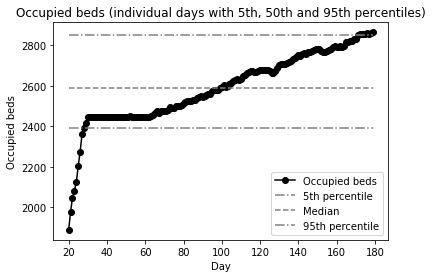

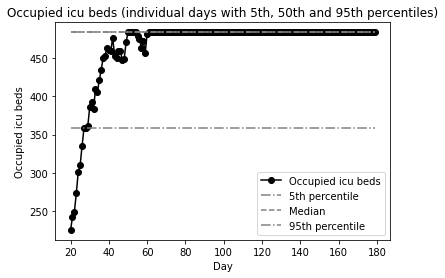

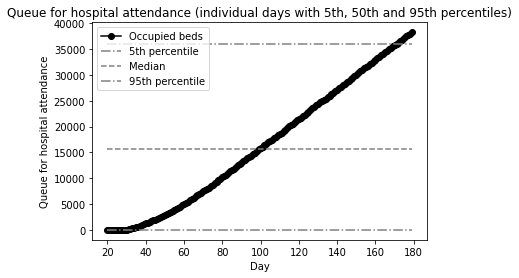

In [349]:
model.hospital.chart()